# Train Custom openWakeWord Model

Windows-compatible version of the openWakeWord training notebook.

## Prerequisites

### Setup the Jupyter kernel (one-time)

```bash
uv add ipykernel --dev
uv run python -m ipykernel install --user --name voice-gateway
```

### Run in VS Code

1. Open this notebook in VS Code
2. Click **Select Kernel** (top right) â†’ **voice-gateway**
3. Run the cells!

## 1. Install Dependencies

In [170]:
# Set to True for NVIDIA GPU support (requires CUDA installed)
USE_GPU = True

In [171]:
import subprocess
import sys

# Install PyTorch with CUDA support from PyTorch's index
if USE_GPU:
    print("Installing PyTorch with CUDA support...")
    subprocess.run([
        "uv", "pip", "install",
        "torch>=2.0,<2.6", "torchaudio",
        "--index-url", "https://download.pytorch.org/whl/cu124"
    ], check=True)
else:
    print("Installing PyTorch (CPU only)...")
    subprocess.run(["uv", "pip", "install", "torch>=2.0,<2.6", "torchaudio"], check=True)

# Verify GPU is available
import torch
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected - will use CPU")

Installing PyTorch with CUDA support...
GPU available: NVIDIA GeForce GTX 1080


In [172]:
# Core dependencies (Windows-compatible)
deps = [
    "piper-tts>=1.2.0",
    "numpy",
    "scipy",
    "tqdm",
    "datasets==2.14.6",
    "pyyaml",
    "onnxruntime",
    "onnx",
    "pronouncing",
    "deep-phonemizer",
    "mutagen",
    "torchinfo",
    "torchmetrics",
    "speechbrain==0.5.14",
    "requests",
    "ipywidgets",
    "soundfile",
]

# Install dependencies
failed = []
for dep in deps:
    result = subprocess.run(["uv", "pip", "install", dep], capture_output=True, text=True)
    if result.returncode != 0:
        failed.append(dep)
        print(f"Failed: {dep}")
    else:
        print(f"Installed: {dep}")

if failed:
    print(f"\nWarning: Failed to install: {failed}")
else:
    print("\nAll dependencies installed successfully!")

Installed: piper-tts>=1.2.0
Installed: numpy
Installed: scipy
Installed: tqdm
Installed: datasets==2.14.6
Installed: pyyaml
Installed: onnxruntime
Installed: onnx
Installed: pronouncing
Installed: deep-phonemizer
Installed: mutagen
Installed: torchinfo
Installed: torchmetrics
Installed: speechbrain==0.5.14
Installed: requests
Installed: ipywidgets
Installed: soundfile

All dependencies installed successfully!


## 2. Setup

In [173]:
import os
import subprocess
import wave
import json
import random
from pathlib import Path
import requests
from tqdm.auto import tqdm
import numpy as np
import torch
import torchaudio
import scipy.signal
from numpy.lib.format import open_memmap

SCRIPT_DIR = Path(".").resolve()
print(f"Working directory: {SCRIPT_DIR}")

Working directory: D:\GitHub\voice-gateway\scripts\wakeword_training


In [174]:
# Download piper voice model (ONNX format - works on Windows)
PIPER_MODELS_DIR = SCRIPT_DIR / "piper_models"
PIPER_MODELS_DIR.mkdir(exist_ok=True)

MODEL_NAME = "en_US-libritts_r-medium"
PIPER_MODEL_PATH = PIPER_MODELS_DIR / f"{MODEL_NAME}.onnx"
PIPER_CONFIG_PATH = PIPER_MODELS_DIR / f"{MODEL_NAME}.onnx.json"

base_url = "https://huggingface.co/rhasspy/piper-voices/resolve/main/en/en_US/libritts_r/medium"

for filepath, filename in [(PIPER_MODEL_PATH, f"{MODEL_NAME}.onnx"), (PIPER_CONFIG_PATH, f"{MODEL_NAME}.onnx.json")]:
    if not filepath.exists():
        print(f"Downloading {filename}...")
        url = f"{base_url}/{filename}"
        response = requests.get(url, stream=True)
        response.raise_for_status()
        total = int(response.headers.get("content-length", 0))
        with open(filepath, "wb") as f:
            with tqdm(total=total, unit="B", unit_scale=True, desc=filename) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
    else:
        print(f"{filename} already exists")

en_US-libritts_r-medium.onnx already exists
en_US-libritts_r-medium.onnx.json already exists


In [175]:
# Clone openwakeword
OWW_DIR = SCRIPT_DIR / "openwakeword"

if not OWW_DIR.exists():
    print("Cloning openwakeword...")
    subprocess.run(["git", "clone", "https://github.com/dscripka/openwakeword"], cwd=SCRIPT_DIR, check=True)
else:
    print("openwakeword already exists")

openwakeword already exists


In [176]:
# Download openwakeword embedding models
OWW_MODELS_DIR = OWW_DIR / "openwakeword" / "resources" / "models"
OWW_MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_urls = {
    "embedding_model.onnx": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/embedding_model.onnx",
    "melspectrogram.onnx": "https://github.com/dscripka/openWakeWord/releases/download/v0.5.1/melspectrogram.onnx",
}

for filename, url in model_urls.items():
    filepath = OWW_MODELS_DIR / filename
    if not filepath.exists():
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(filepath, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f"{filename} already exists")

embedding_model.onnx already exists
melspectrogram.onnx already exists


## 3. Download Augmentation Data

Download room impulse responses (RIRs) and background noise for data augmentation.
This significantly improves model quality by simulating real-world acoustic conditions.

In [177]:
import zipfile
import tarfile

AUGMENT_DIR = SCRIPT_DIR / "augmentation_data"
AUGMENT_DIR.mkdir(exist_ok=True)

RIR_DIR = AUGMENT_DIR / "rir"
NOISE_DIR = AUGMENT_DIR / "noise"

In [178]:
# Download MIT Acoustics RIR dataset (small, ~50MB)
RIR_DIR.mkdir(exist_ok=True)

# Using the OpenSLR RIR dataset (simulated room impulse responses)
RIR_URL = "https://www.openslr.org/resources/28/rirs_noises.zip"
RIR_ZIP = AUGMENT_DIR / "rirs_noises.zip"

if not (RIR_DIR / "RIRS_NOISES").exists():
    if not RIR_ZIP.exists():
        print("Downloading RIR dataset (~300MB)...")
        response = requests.get(RIR_URL, stream=True)
        response.raise_for_status()
        total = int(response.headers.get("content-length", 0))
        with open(RIR_ZIP, "wb") as f:
            with tqdm(total=total, unit="B", unit_scale=True, desc="RIR dataset") as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
    
    print("Extracting RIR dataset...")
    with zipfile.ZipFile(RIR_ZIP, 'r') as z:
        z.extractall(RIR_DIR)
    print("RIR dataset ready")
else:
    print("RIR dataset already exists")

RIR dataset already exists


In [179]:
# Download MUSAN noise dataset (background noise, music, babble)
NOISE_DIR.mkdir(exist_ok=True)

MUSAN_URL = "https://www.openslr.org/resources/17/musan.tar.gz"
MUSAN_TAR = AUGMENT_DIR / "musan.tar.gz"

if not (NOISE_DIR / "musan").exists():
    if not MUSAN_TAR.exists():
        print("Downloading MUSAN noise dataset (~11GB, this will take a while)...")
        response = requests.get(MUSAN_URL, stream=True)
        response.raise_for_status()
        total = int(response.headers.get("content-length", 0))
        with open(MUSAN_TAR, "wb") as f:
            with tqdm(total=total, unit="B", unit_scale=True, desc="MUSAN dataset") as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    pbar.update(len(chunk))
    
    print("Extracting MUSAN dataset (this may take a few minutes)...")
    with tarfile.open(MUSAN_TAR, 'r:gz') as tar:
        tar.extractall(NOISE_DIR)
    print("MUSAN dataset ready")
else:
    print("MUSAN dataset already exists")

MUSAN dataset already exists


In [180]:
# Collect all RIR and noise file paths
rir_paths = []
for ext in ["*.wav", "*.flac"]:
    rir_paths.extend(list((RIR_DIR / "RIRS_NOISES" / "simulated_rirs").rglob(ext)))
    rir_paths.extend(list((RIR_DIR / "RIRS_NOISES" / "real_rirs_isotropic_noises").rglob(ext)))

noise_paths = []
musan_dir = NOISE_DIR / "musan"
if musan_dir.exists():
    # Include noise and music, skip speech (we want non-speech background)
    noise_paths.extend(list((musan_dir / "noise").rglob("*.wav")))
    noise_paths.extend(list((musan_dir / "music").rglob("*.wav")))

print(f"Found {len(rir_paths)} RIR files")
print(f"Found {len(noise_paths)} noise/music files")

Found 60417 RIR files
Found 1590 noise/music files


## 4. Test Wake Word Pronunciation

Before training, verify the TTS pronounces your wake word correctly.

**Tips:**
- If pronunciation is wrong, spell it phonetically with underscores: `"hey_seer_e"` for "hey siri"
- Spell out numbers: `"two"` not `"2"`
- Avoid punctuation except `?` and `!`

In [181]:
# Configure your wake word here!
TARGET_WORD = "Seraphina"  # Change this to your desired wake word

In [182]:
from piper import PiperVoice
from piper.config import SynthesisConfig
from IPython.display import Audio, display

# Load the voice model
voice = PiperVoice.load(str(PIPER_MODEL_PATH), str(PIPER_CONFIG_PATH))

# Get number of speakers
with open(PIPER_CONFIG_PATH, encoding="utf-8") as f:
    voice_config = json.load(f)
num_speakers = voice_config.get("num_speakers", 1)
print(f"Voice model loaded with {num_speakers} speakers")

Voice model loaded with 904 speakers


In [183]:
def generate_sample(text: str, output_path: Path, speaker_id: int = 0, 
                    length_scale: float = 1.0, noise_scale: float = 0.667, 
                    noise_w_scale: float = 0.8):
    """Generate a single audio sample using piper-tts."""
    config = SynthesisConfig(
        speaker_id=speaker_id,
        length_scale=length_scale,
        noise_scale=noise_scale,
        noise_w_scale=noise_w_scale,
    )
    
    with wave.open(str(output_path), "wb") as wav_file:
        voice.synthesize_wav(text, wav_file, syn_config=config)

# Test pronunciation
test_path = SCRIPT_DIR / "test_generation.wav"
generate_sample(TARGET_WORD, test_path, speaker_id=0, length_scale=1.1)
display(Audio(str(test_path), autoplay=True))
print(f"\nTest audio saved to: {test_path}")


Test audio saved to: D:\GitHub\voice-gateway\scripts\wakeword_training\test_generation.wav


In [184]:
# Try different speakers to hear variations
print("Generating samples with different speakers...")
for speaker_id in range(min(5, num_speakers)):
    sample_path = SCRIPT_DIR / f"test_speaker_{speaker_id}.wav"
    generate_sample(TARGET_WORD, sample_path, speaker_id=speaker_id)
    print(f"Speaker {speaker_id}:")
    display(Audio(str(sample_path), autoplay=False))

Generating samples with different speakers...
Speaker 0:


Speaker 1:


Speaker 2:


Speaker 3:


Speaker 4:


## 5. Generate Training Samples

Generate diverse audio samples of the wake word using different speakers and synthesis parameters.

In [185]:
# Training sample configuration
N_SAMPLES_TRAIN = 2000  # Training samples (more = better, but slower)
N_SAMPLES_TEST = 200    # Test/validation samples
AUGMENTATION_ROUNDS = 3  # How many augmented versions of each sample to create

# Output directories matching openwakeword's expected structure
MODEL_OUTPUT_NAME = TARGET_WORD.replace(" ", "_")
OUTPUT_DIR = SCRIPT_DIR / "my_custom_model"
MODEL_DIR = OUTPUT_DIR / MODEL_OUTPUT_NAME

POSITIVE_TRAIN_DIR = MODEL_DIR / "positive_train"
POSITIVE_TEST_DIR = MODEL_DIR / "positive_test"
NEGATIVE_TRAIN_DIR = MODEL_DIR / "negative_train"
NEGATIVE_TEST_DIR = MODEL_DIR / "negative_test"

for d in [POSITIVE_TRAIN_DIR, POSITIVE_TEST_DIR, NEGATIVE_TRAIN_DIR, NEGATIVE_TEST_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {MODEL_DIR}")

Output directory: D:\GitHub\voice-gateway\scripts\wakeword_training\my_custom_model\Seraphina


In [186]:
def generate_samples_batch(text: str, output_dir: Path, n_samples: int, desc: str = "Generating"):
    """Generate diverse training samples."""
    # Parameter ranges for variation
    length_scales = [0.8, 0.9, 1.0, 1.1, 1.2]
    noise_scales = [0.5, 0.667, 0.8]
    noise_w_scales = [0.6, 0.8, 1.0]
    
    generated = 0
    for i in tqdm(range(n_samples), desc=desc):
        output_path = output_dir / f"sample_{i:05d}.wav"
        
        if output_path.exists():
            generated += 1
            continue
        
        speaker_id = random.randint(0, num_speakers - 1)
        length_scale = random.choice(length_scales)
        noise_scale = random.choice(noise_scales)
        noise_w_scale = random.choice(noise_w_scales)
        
        try:
            generate_sample(
                text, output_path,
                speaker_id=speaker_id,
                length_scale=length_scale,
                noise_scale=noise_scale,
                noise_w_scale=noise_w_scale,
            )
            generated += 1
        except Exception as e:
            print(f"Failed sample {i}: {e}")
    
    return generated

# Generate positive samples
print(f"\nGenerating {N_SAMPLES_TRAIN} positive training samples...")
n = generate_samples_batch(TARGET_WORD, POSITIVE_TRAIN_DIR, N_SAMPLES_TRAIN, "Positive train")
print(f"Generated {n} training samples")

print(f"\nGenerating {N_SAMPLES_TEST} positive test samples...")
n = generate_samples_batch(TARGET_WORD, POSITIVE_TEST_DIR, N_SAMPLES_TEST, "Positive test")
print(f"Generated {n} test samples")


Generating 2000 positive training samples...


Positive train:   0%|          | 0/2000 [00:00<?, ?it/s]

Generated 2000 training samples

Generating 200 positive test samples...


Positive test:   0%|          | 0/200 [00:00<?, ?it/s]

Generated 200 test samples


In [187]:
# Generate adversarial negative samples (similar-sounding words)
# Inlined from openwakeword.data to avoid audiomentations dependency
import itertools
import re
import pronouncing

def phoneme_replacement(input_chars, max_replace, replace_char='(.){1,3}'):
    """Generate regex patterns with phonemes replaced."""
    results = []
    chars = list(input_chars)
    for r in range(1, max_replace + 1):
        comb = itertools.combinations(range(len(chars)), r)
        for indices in comb:
            chars_copy = chars.copy()
            for i in indices:
                chars_copy[i] = replace_char
            results.append(' '.join(chars_copy))
    return results

def generate_adversarial_texts(input_text: str, N: int, include_partial_phrase: float = 0, include_input_words: float = 0):
    """Generate adversarial words based on phoneme overlap."""
    vowel_phones = ["AA", "AE", "AH", "AO", "AW", "AX", "AXR", "AY", "EH", "ER", "EY", "IH", "IX", "IY", "OW", "OY", "UH", "UW", "UX"]
    
    word_phones = []
    input_text_phones = [pronouncing.phones_for_word(i) for i in input_text.split()]
    
    # Handle OOV words with simple fallback
    for phones, word in zip(input_text_phones, input_text.split()):
        if phones:
            word_phones.append(phones[0] if isinstance(phones[0], str) else phones[0])
        else:
            # Simple fallback for OOV words - use the word itself
            print(f"Warning: '{word}' not in pronunciation dictionary, using simple phoneme approximation")
            word_phones.append(word.upper())
    
    # Add lexical stress variants to vowels
    word_phones = [re.sub('|'.join(vowel_phones), lambda x: str(x.group(0)) + '[0|1|2]', re.sub(r'\\d+', '', i)) for i in word_phones]
    
    adversarial_phrases = []
    for phones, word in zip(word_phones, input_text.split()):
        query_exps = []
        phones_list = phones.split()
        adversarial_words = []
        if len(phones_list) <= 2:
            query_exps.append(" ".join(phones_list))
        else:
            query_exps.extend(phoneme_replacement(phones_list, max_replace=max(0, len(phones_list)-2), replace_char="(.){1,3}"))
        
        for query in query_exps:
            try:
                matches = pronouncing.search(query)
                matches_phones = [pronouncing.phones_for_word(i)[0] for i in matches if pronouncing.phones_for_word(i)]
                allowed_matches = [i for i, j in zip(matches, matches_phones) if j != phones]
                adversarial_words.extend([i for i in allowed_matches if word.lower() != i])
            except Exception:
                pass
        
        if adversarial_words:
            adversarial_phrases.append(adversarial_words)
    
    # Build combinations
    adversarial_texts = []
    if not adversarial_phrases:
        return adversarial_texts
    
    for i in range(N):
        txts = []
        for j, k in zip(adversarial_phrases, input_text.split()):
            if np.random.random() > (1 - include_input_words):
                txts.append(k)
            else:
                txts.append(np.random.choice(j))
        
        if include_partial_phrase and len(input_text.split()) > 1 and np.random.random() <= include_partial_phrase:
            n_words = np.random.randint(1, len(input_text.split()) + 1)
            adversarial_texts.append(" ".join(np.random.choice(txts, size=n_words, replace=False)))
        else:
            adversarial_texts.append(" ".join(txts))
    
    # Remove exact matches
    adversarial_texts = [i for i in adversarial_texts if i != input_text]
    return adversarial_texts

# Generate adversarial texts
adversarial_texts = []
for word in TARGET_WORD.split():
    adversarial_texts.extend(generate_adversarial_texts(
        input_text=word,
        N=N_SAMPLES_TRAIN // max(1, len(TARGET_WORD.split())),
        include_partial_phrase=0.5,
        include_input_words=0.2
    ))

print(f"Generated {len(adversarial_texts)} adversarial phrases")
print(f"Examples: {adversarial_texts[:5]}")

Generated 1616 adversarial phrases
Examples: ['swiftly', 'ostankino', 'self-deprecating', 'stefanic', 'centeno']


In [188]:
# Generate negative training samples
print(f"\nGenerating {N_SAMPLES_TRAIN} negative training samples...")

length_scales = [0.8, 0.9, 1.0, 1.1, 1.2]
noise_scales = [0.5, 0.667, 0.8]
noise_w_scales = [0.6, 0.8, 1.0]

generated = 0
for i in tqdm(range(N_SAMPLES_TRAIN), desc="Negative train"):
    output_path = NEGATIVE_TRAIN_DIR / f"sample_{i:05d}.wav"
    if output_path.exists():
        generated += 1
        continue
    
    text = random.choice(adversarial_texts)
    speaker_id = random.randint(0, num_speakers - 1)
    
    try:
        generate_sample(
            text, output_path,
            speaker_id=speaker_id,
            length_scale=random.choice(length_scales),
            noise_scale=random.choice(noise_scales),
            noise_w_scale=random.choice(noise_w_scales),
        )
        generated += 1
    except Exception as e:
        pass  # Some adversarial texts may fail, that's ok

print(f"Generated {generated} negative training samples")


Generating 2000 negative training samples...


Negative train:   0%|          | 0/2000 [00:00<?, ?it/s]

Generated 2000 negative training samples


In [189]:
# Generate negative test samples
print(f"\nGenerating {N_SAMPLES_TEST} negative test samples...")

generated = 0
for i in tqdm(range(N_SAMPLES_TEST), desc="Negative test"):
    output_path = NEGATIVE_TEST_DIR / f"sample_{i:05d}.wav"
    if output_path.exists():
        generated += 1
        continue
    
    text = random.choice(adversarial_texts)
    speaker_id = random.randint(0, num_speakers - 1)
    
    try:
        generate_sample(
            text, output_path,
            speaker_id=speaker_id,
            length_scale=random.choice(length_scales),
            noise_scale=random.choice(noise_scales),
            noise_w_scale=random.choice(noise_w_scales),
        )
        generated += 1
    except Exception as e:
        pass

print(f"Generated {generated} negative test samples")


Generating 200 negative test samples...


Negative test:   0%|          | 0/200 [00:00<?, ?it/s]

Generated 200 negative test samples


## 6. Data Augmentation (Windows-Compatible)

Apply audio augmentations to simulate real-world conditions:
- Room reverb (RIR convolution)
- Background noise mixing
- Volume variation
- Pitch shifting
- Speed variation

In [190]:
def load_audio(path: Path, target_sr: int = 16000) -> torch.Tensor:
    """Load audio file and resample to target sample rate."""
    waveform, sr = torchaudio.load(str(path))
    if sr != target_sr:
        resampler = torchaudio.transforms.Resample(sr, target_sr)
        waveform = resampler(waveform)
    # Convert to mono if stereo
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    return waveform.squeeze(0)


def apply_rir(waveform: torch.Tensor, rir: torch.Tensor) -> torch.Tensor:
    """Apply room impulse response via convolution."""
    # Normalize RIR
    rir = rir / (rir.abs().max() + 1e-8)
    # Convolve
    result = torch.nn.functional.conv1d(
        waveform.unsqueeze(0).unsqueeze(0),
        rir.unsqueeze(0).unsqueeze(0),
        padding=rir.shape[0] // 2
    ).squeeze()
    # Trim to original length
    return result[:waveform.shape[0]]


def mix_audio(foreground: torch.Tensor, background: torch.Tensor, snr_db: float) -> torch.Tensor:
    """Mix foreground with background at specified SNR."""
    # Ensure background is long enough
    while background.shape[0] < foreground.shape[0]:
        background = torch.cat([background, background])
    
    # Random start position in background
    max_start = background.shape[0] - foreground.shape[0]
    if max_start > 0:
        start = random.randint(0, max_start)
        background = background[start:start + foreground.shape[0]]
    else:
        background = background[:foreground.shape[0]]
    
    # Calculate scaling for desired SNR
    fg_rms = foreground.pow(2).mean().sqrt() + 1e-8
    bg_rms = background.pow(2).mean().sqrt() + 1e-8
    snr_linear = 10 ** (snr_db / 20)
    scale = fg_rms / (bg_rms * snr_linear)
    
    mixed = foreground + background * scale
    # Normalize to prevent clipping
    max_val = mixed.abs().max()
    if max_val > 1.0:
        mixed = mixed / max_val
    
    return mixed


def create_fixed_length_clip(waveform: torch.Tensor, target_length: int, 
                              end_jitter_ms: int = 200, sr: int = 16000) -> torch.Tensor:
    """Pad/truncate clip to fixed length, with the clip near the end."""
    result = torch.zeros(target_length)
    
    # Random jitter for end position
    end_jitter_samples = int(random.uniform(0, end_jitter_ms / 1000) * sr)
    
    if waveform.shape[0] >= target_length:
        # Truncate - take from random position
        if random.random() > 0.5:
            result = waveform[:target_length]
        else:
            result = waveform[-target_length:]
    else:
        # Pad - position clip near end with jitter
        start = max(0, target_length - waveform.shape[0] - end_jitter_samples)
        end = start + waveform.shape[0]
        result[start:end] = waveform
    
    return result


def augment_clip(waveform: torch.Tensor, 
                 target_length: int,
                 rir_paths: list,
                 noise_paths: list,
                 sr: int = 16000,
                 rir_prob: float = 0.5,
                 noise_prob: float = 0.75,
                 pitch_shift_prob: float = 0.25,
                 speed_prob: float = 0.25) -> torch.Tensor:
    """Apply augmentations to a single clip."""
    
    # Speed perturbation (before padding)
    if random.random() < speed_prob:
        speed_factor = random.uniform(0.9, 1.1)
        effects = [["speed", str(speed_factor)], ["rate", str(sr)]]
        waveform_np = waveform.numpy()
        waveform, _ = torchaudio.sox_effects.apply_effects_tensor(
            torch.from_numpy(waveform_np).unsqueeze(0), sr, effects
        )
        waveform = waveform.squeeze(0)
    
    # Pitch shift
    if random.random() < pitch_shift_prob:
        n_steps = random.uniform(-3, 3)
        waveform = torchaudio.functional.pitch_shift(waveform.unsqueeze(0), sr, n_steps).squeeze(0)
    
    # Create fixed-length clip
    waveform = create_fixed_length_clip(waveform, target_length, sr=sr)
    
    # Apply RIR (reverb)
    if rir_paths and random.random() < rir_prob:
        try:
            rir = load_audio(random.choice(rir_paths), sr)
            waveform = apply_rir(waveform, rir)
        except Exception:
            pass  # Skip if RIR loading fails
    
    # Mix with background noise
    if noise_paths and random.random() < noise_prob:
        try:
            noise = load_audio(random.choice(noise_paths), sr)
            snr_db = random.uniform(-5, 20)  # Wide range of SNRs
            waveform = mix_audio(waveform, noise, snr_db)
        except Exception:
            pass  # Skip if noise loading fails
    
    # Volume augmentation
    volume = random.uniform(0.1, 1.0)
    waveform = waveform * (volume / (waveform.abs().max() + 1e-8))
    
    return waveform


def augment_clips_generator(clip_paths: list,
                            target_length: int,
                            rir_paths: list,
                            noise_paths: list,
                            batch_size: int = 64,
                            augmentation_rounds: int = 1,
                            sr: int = 16000):
    """Generator that yields batches of augmented clips as 16-bit PCM."""
    
    # Expand clip list for augmentation rounds
    all_clips = clip_paths * augmentation_rounds
    random.shuffle(all_clips)
    
    for i in range(0, len(all_clips), batch_size):
        batch_paths = all_clips[i:i + batch_size]
        batch = []
        
        for clip_path in batch_paths:
            try:
                waveform = load_audio(clip_path, sr)
                augmented = augment_clip(
                    waveform, target_length, rir_paths, noise_paths, sr
                )
                # Convert to 16-bit PCM
                pcm = (augmented.numpy() * 32767).astype(np.int16)
                batch.append(pcm)
            except Exception as e:
                continue  # Skip failed clips
        
        if batch:
            yield np.stack(batch)

print("Augmentation functions defined")

Augmentation functions defined


In [191]:
# Determine clip length from samples
positive_clips = list(POSITIVE_TEST_DIR.glob("*.wav"))
durations = []
for clip in positive_clips[:50]:
    waveform = load_audio(clip)
    durations.append(waveform.shape[0])

median_duration = int(np.median(durations))
# Add 750ms buffer and round to nearest 1000
TOTAL_LENGTH = int(np.ceil((median_duration + 12000) / 1000) * 1000)
# Minimum 2 seconds
TOTAL_LENGTH = max(TOTAL_LENGTH, 32000)
# Clamp near 32000 to exactly 32000
if abs(TOTAL_LENGTH - 32000) <= 4000:
    TOTAL_LENGTH = 32000

print(f"Median clip duration: {median_duration} samples ({median_duration/16000:.2f}s)")
print(f"Target augmented length: {TOTAL_LENGTH} samples ({TOTAL_LENGTH/16000:.2f}s)")

Median clip duration: 12539 samples (0.78s)
Target augmented length: 32000 samples (2.00s)


In [192]:
# Test augmentation on a single clip
test_clip = list(POSITIVE_TRAIN_DIR.glob("*.wav"))[0]
waveform = load_audio(test_clip)
augmented = augment_clip(waveform, TOTAL_LENGTH, rir_paths, noise_paths)

print(f"Original shape: {waveform.shape}")
print(f"Augmented shape: {augmented.shape}")

# Save test augmentation
test_aug_path = SCRIPT_DIR / "test_augmented.wav"
torchaudio.save(str(test_aug_path), augmented.unsqueeze(0), 16000)
display(Audio(str(test_aug_path), autoplay=False))
print(f"\nTest augmented audio saved to: {test_aug_path}")

Original shape: torch.Size([12261])
Augmented shape: torch.Size([32000])



Test augmented audio saved to: D:\GitHub\voice-gateway\scripts\wakeword_training\test_augmented.wav


## 7. Compute Features

Convert augmented audio to openWakeWord features and save as numpy arrays.

In [193]:
# Import openwakeword feature computation
import sys
sys.path.insert(0, str(OWW_DIR))
from openwakeword.utils import AudioFeatures

# Initialize feature extractor
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

feature_extractor = AudioFeatures(device=device)

Using device: gpu


In [194]:
def compute_features_from_augmented_generator(generator, n_total: int, clip_duration: int,
                                               output_file: str, feature_extractor):
    """Compute openWakeWord features from augmented audio generator."""
    
    # Calculate output shape
    # Features are computed every 1280 samples (80ms), starting after 12400 samples (775ms)
    n_features_per_clip = (clip_duration - 12400) // 1280 + 1
    feature_dim = 96  # openWakeWord embedding dimension
    
    # Create memory-mapped output file
    output_shape = (n_total, n_features_per_clip, feature_dim)
    mmap_file = open_memmap(output_file, mode='w+', dtype=np.float32, shape=output_shape)
    
    idx = 0
    pbar = tqdm(total=n_total, desc="Computing features")
    
    for batch in generator:
        # batch is (batch_size, samples) as int16
        for clip in batch:
            if idx >= n_total:
                break
            
            # Compute features for single clip
            features = feature_extractor.embed_clips(clip[np.newaxis, :], batch_size=1)
            
            if features.shape[1] == n_features_per_clip:
                mmap_file[idx] = features[0]
                idx += 1
                pbar.update(1)
        
        mmap_file.flush()
        
        if idx >= n_total:
            break
    
    pbar.close()
    print(f"Saved {idx} feature vectors to {output_file}")
    return idx

In [195]:
# Check if features already exist
positive_train_features = MODEL_DIR / "positive_features_train.npy"
positive_test_features = MODEL_DIR / "positive_features_test.npy"
negative_train_features = MODEL_DIR / "negative_features_train.npy"
negative_test_features = MODEL_DIR / "negative_features_test.npy"

RECOMPUTE_FEATURES = False  # Set to True to recompute even if files exist

all_exist = all(f.exists() for f in [
    positive_train_features, positive_test_features,
    negative_train_features, negative_test_features
])

if all_exist and not RECOMPUTE_FEATURES:
    print("Feature files already exist. Set RECOMPUTE_FEATURES=True to regenerate.")
else:
    print("Will compute features for all samples...")

Feature files already exist. Set RECOMPUTE_FEATURES=True to regenerate.


In [196]:
if not positive_train_features.exists() or RECOMPUTE_FEATURES:
    print("\n" + "="*50)
    print("Computing positive training features...")
    print("="*50)
    
    clip_paths = list(POSITIVE_TRAIN_DIR.glob("*.wav"))
    n_total = len(clip_paths) * AUGMENTATION_ROUNDS
    
    generator = augment_clips_generator(
        clip_paths, TOTAL_LENGTH, rir_paths, noise_paths,
        batch_size=64, augmentation_rounds=AUGMENTATION_ROUNDS
    )
    
    compute_features_from_augmented_generator(
        generator, n_total, TOTAL_LENGTH,
        str(positive_train_features), feature_extractor
    )

In [197]:
if not negative_train_features.exists() or RECOMPUTE_FEATURES:
    print("\n" + "="*50)
    print("Computing negative training features...")
    print("="*50)
    
    clip_paths = list(NEGATIVE_TRAIN_DIR.glob("*.wav"))
    n_total = len(clip_paths) * AUGMENTATION_ROUNDS
    
    generator = augment_clips_generator(
        clip_paths, TOTAL_LENGTH, rir_paths, noise_paths,
        batch_size=64, augmentation_rounds=AUGMENTATION_ROUNDS
    )
    
    compute_features_from_augmented_generator(
        generator, n_total, TOTAL_LENGTH,
        str(negative_train_features), feature_extractor
    )

In [198]:
if not positive_test_features.exists() or RECOMPUTE_FEATURES:
    print("\n" + "="*50)
    print("Computing positive test features...")
    print("="*50)
    
    clip_paths = list(POSITIVE_TEST_DIR.glob("*.wav"))
    n_total = len(clip_paths) * AUGMENTATION_ROUNDS
    
    generator = augment_clips_generator(
        clip_paths, TOTAL_LENGTH, rir_paths, noise_paths,
        batch_size=64, augmentation_rounds=AUGMENTATION_ROUNDS
    )
    
    compute_features_from_augmented_generator(
        generator, n_total, TOTAL_LENGTH,
        str(positive_test_features), feature_extractor
    )

In [199]:
if not negative_test_features.exists() or RECOMPUTE_FEATURES:
    print("\n" + "="*50)
    print("Computing negative test features...")
    print("="*50)
    
    clip_paths = list(NEGATIVE_TEST_DIR.glob("*.wav"))
    n_total = len(clip_paths) * AUGMENTATION_ROUNDS
    
    generator = augment_clips_generator(
        clip_paths, TOTAL_LENGTH, rir_paths, noise_paths,
        batch_size=64, augmentation_rounds=AUGMENTATION_ROUNDS
    )
    
    compute_features_from_augmented_generator(
        generator, n_total, TOTAL_LENGTH,
        str(negative_test_features), feature_extractor
    )

In [200]:
# Verify feature files
print("Feature files:")
for f in [positive_train_features, positive_test_features, negative_train_features, negative_test_features]:
    if f.exists():
        data = np.load(str(f), mmap_mode="r")
        print(f"  {f.name}: shape={data.shape}")
    else:
        print(f"  {f.name}: NOT FOUND")


Feature files:
  positive_features_train.npy: shape=(6000, 16, 96)
  positive_features_test.npy: shape=(600, 16, 96)
  negative_features_train.npy: shape=(6000, 16, 96)
  negative_features_test.npy: shape=(600, 16, 96)


## 8. Download Training Data

Download pre-computed negative examples for training (diverse speech that's NOT your wake word).

In [201]:
SKIP_LARGE_DOWNLOAD = False  # Set to True to skip the 16GB download

In [202]:
# Download validation features (small, always download)
VAL_PATH = SCRIPT_DIR / "validation_set_features.npy"

if not VAL_PATH.exists():
    print("Downloading validation features...")
    url = "https://huggingface.co/datasets/davidscripka/openwakeword_features/resolve/main/validation_set_features.npy"
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total = int(response.headers.get("content-length", 0))
    with open(VAL_PATH, "wb") as f:
        with tqdm(total=total, unit="B", unit_scale=True, desc="Validation features") as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
else:
    print("Validation features already downloaded")

Validation features already downloaded


In [203]:
# Download training features (large)
FEATURES_PATH = SCRIPT_DIR / "openwakeword_features_ACAV100M_2000_hrs_16bit.npy"

if SKIP_LARGE_DOWNLOAD:
    print("Skipping large feature download (training quality will be reduced)")
elif not FEATURES_PATH.exists():
    print("Downloading training features (16GB, this will take a while)...")
    url = "https://huggingface.co/datasets/davidscripka/openwakeword_features/resolve/main/openwakeword_features_ACAV100M_2000_hrs_16bit.npy"
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total = int(response.headers.get("content-length", 0))
    with open(FEATURES_PATH, "wb") as f:
        with tqdm(total=total, unit="B", unit_scale=True, desc="Training features") as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
else:
    print("Training features already downloaded")

Training features already downloaded


## 9. Train the Model

Now we train using openwakeword's training script, but skip the augmentation step since we already computed features.

In [204]:
# Training parameters
# NOTE: Start with lower penalty and increase if too many false positives
# Too high penalty (e.g., 1500) causes model collapse (predicts all zeros)
N_STEPS = 10000
FALSE_ACTIVATION_PENALTY = 50  # Start low, increase if needed

In [205]:
import yaml

# Load default config
with open(OWW_DIR / "examples" / "custom_model.yml") as f:
    config = yaml.safe_load(f)

# Modify config
config["target_phrase"] = [TARGET_WORD]
config["model_name"] = MODEL_OUTPUT_NAME
config["output_dir"] = str(OUTPUT_DIR)
config["steps"] = N_STEPS
config["max_negative_weight"] = FALSE_ACTIVATION_PENALTY
config["target_accuracy"] = 0.5
config["target_recall"] = 0.25

# Data paths - use our pre-computed features
config["false_positive_validation_data_path"] = str(VAL_PATH)

# Feature files for negative examples
if FEATURES_PATH.exists():
    config["feature_data_files"] = {"ACAV100M_sample": str(FEATURES_PATH)}
else:
    config["feature_data_files"] = {}

# These won't be used since we skip generation/augmentation
config["background_paths"] = []
config["rir_paths"] = []
config["n_samples"] = N_SAMPLES_TRAIN
config["n_samples_val"] = N_SAMPLES_TEST

# Save config
CONFIG_YAML_PATH = SCRIPT_DIR / "my_model.yaml"
with open(CONFIG_YAML_PATH, "w") as f:
    yaml.dump(config, f)

print(f"Config saved to: {CONFIG_YAML_PATH}")
print(f"\nTraining configuration:")
print(f"  Target word: {TARGET_WORD}")
print(f"  Steps: {N_STEPS}")
print(f"  False activation penalty: {FALSE_ACTIVATION_PENALTY}")
print(f"  Output: {OUTPUT_DIR}")

Config saved to: D:\GitHub\voice-gateway\scripts\wakeword_training\my_model.yaml

Training configuration:
  Target word: Seraphina
  Steps: 10000
  False activation penalty: 1500
  Output: D:\GitHub\voice-gateway\scripts\wakeword_training\my_custom_model


In [206]:
# Inlined Model class and mmap_batch_generator from openwakeword
# to avoid audiomentations dependency

import copy
import collections
import torch
from torch import optim, nn
import torchinfo
import torchmetrics
import numpy as np

class Model(nn.Module):
    """openWakeWord training model (inlined to avoid audiomentations import)."""
    
    def __init__(self, n_classes=1, input_shape=(16, 96), model_type="dnn",
                 layer_dim=128, n_blocks=1, seconds_per_example=None):
        super().__init__()
        self.n_classes = n_classes
        self.input_shape = input_shape
        self.seconds_per_example = seconds_per_example
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.best_models = []
        self.best_model_scores = []
        self.best_val_fp = 1000
        self.best_val_accuracy = 0
        self.best_val_recall = 0
        self.best_train_recall = 0

        if model_type == "dnn":
            class FCNBlock(nn.Module):
                def __init__(self, layer_dim):
                    super().__init__()
                    self.fcn_layer = nn.Linear(layer_dim, layer_dim)
                    self.relu = nn.ReLU()
                    self.layer_norm = nn.LayerNorm(layer_dim)
                def forward(self, x):
                    return self.relu(self.layer_norm(self.fcn_layer(x)))

            class Net(nn.Module):
                def __init__(self, input_shape, layer_dim, n_blocks=1, n_classes=1):
                    super().__init__()
                    self.flatten = nn.Flatten()
                    self.layer1 = nn.Linear(input_shape[0]*input_shape[1], layer_dim)
                    self.relu1 = nn.ReLU()
                    self.layernorm1 = nn.LayerNorm(layer_dim)
                    self.blocks = nn.ModuleList([FCNBlock(layer_dim) for i in range(n_blocks)])
                    self.last_layer = nn.Linear(layer_dim, n_classes)
                    self.last_act = nn.Sigmoid() if n_classes == 1 else nn.ReLU()
                def forward(self, x):
                    x = self.relu1(self.layernorm1(self.layer1(self.flatten(x))))
                    for block in self.blocks:
                        x = block(x)
                    x = self.last_act(self.last_layer(x))
                    return x
            self.model = Net(input_shape, layer_dim, n_blocks=n_blocks, n_classes=n_classes)

        # Metrics
        self.fp = lambda pred, y: (y-pred <= -0.5).sum()
        self.recall = torchmetrics.Recall(task='binary')
        self.accuracy = torchmetrics.Accuracy(task='binary')
        self.n_fp = 0
        self.val_fp = 0
        self.history = collections.defaultdict(list)
        self.loss = torch.nn.functional.binary_cross_entropy
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def forward(self, x):
        return self.model(x)

    def summary(self):
        return torchinfo.summary(self.model, input_size=(1,) + self.input_shape, device='cpu')

    def lr_warmup_cosine_decay(self, global_step, warmup_steps=0, hold=0, total_steps=0, start_lr=0.0, target_lr=1e-3):
        learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
        warmup_lr = target_lr * (global_step / warmup_steps) if warmup_steps > 0 else target_lr
        if hold > 0:
            learning_rate = np.where(global_step > warmup_steps + hold, learning_rate, target_lr)
        learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
        return learning_rate

    def average_models(self, models=None):
        if models is None:
            models = self.best_models
        averaged_model = copy.deepcopy(models[0])
        averaged_model_dict = averaged_model.state_dict()
        for key in averaged_model_dict:
            averaged_model_dict[key] *= 0
        for model in models:
            model_dict = model.state_dict()
            for key, value in model_dict.items():
                averaged_model_dict[key] += value
        for key in averaged_model_dict:
            averaged_model_dict[key] /= len(models)
        averaged_model.load_state_dict(averaged_model_dict)
        return averaged_model

    def export_model(self, model, model_name, output_dir):
        import os
        model_to_save = copy.deepcopy(model)
        torch.onnx.export(model_to_save.to("cpu"), torch.rand(self.input_shape)[None, ],
                          os.path.join(output_dir, model_name + ".onnx"), opset_version=13)

    def train_model(self, X, max_steps, warmup_steps, hold_steps, X_val=None,
                    false_positive_val_data=None, negative_weight_schedule=[1],
                    val_steps=[250], lr=0.0001, val_set_hrs=1):
        from tqdm.auto import tqdm
        self.to(self.device)
        self.model.to(self.device)
        
        accumulation_steps = 1
        accumulated_samples = 0
        accumulated_predictions = torch.Tensor([]).to(self.device)
        accumulated_labels = torch.Tensor([]).to(self.device)
        
        for step_ndx, data in tqdm(enumerate(X, 0), total=max_steps, desc="Training"):
            x, y = data[0].to(self.device), data[1].to(self.device)
            y_ = y[..., None].to(torch.float32)

            for g in self.optimizer.param_groups:
                g['lr'] = self.lr_warmup_cosine_decay(step_ndx, warmup_steps=warmup_steps, hold=hold_steps,
                                                      total_steps=max_steps, target_lr=lr)
            self.optimizer.zero_grad()
            predictions = self.model(x)

            neg_high_loss = predictions[(y == 0) & (predictions.squeeze() >= 0.001)]
            pos_high_loss = predictions[(y == 1) & (predictions.squeeze() < 0.999)]
            y = torch.cat((y[(y == 0) & (predictions.squeeze() >= 0.001)], y[(y == 1) & (predictions.squeeze() < 0.999)]))
            y_ = y[..., None].to(torch.float32)
            predictions = torch.cat((neg_high_loss, pos_high_loss))

            if len(negative_weight_schedule) == 1:
                w = torch.ones(y.shape[0])*negative_weight_schedule[0]
            else:
                w = torch.ones(y.shape[0])*negative_weight_schedule[min(step_ndx, len(negative_weight_schedule)-1)]
            pos_ndcs = y == 1
            w[pos_ndcs] = 1
            w = w[..., None]

            if predictions.shape[0] != 0:
                loss = self.loss(predictions, y_, w.to(self.device))
                loss = loss/accumulation_steps
                accumulated_samples += predictions.shape[0]

                if predictions.shape[0] >= 128:
                    accumulated_predictions = predictions
                    accumulated_labels = y_
                if accumulated_samples < 128:
                    accumulation_steps += 1
                    accumulated_predictions = torch.cat((accumulated_predictions, predictions))
                    accumulated_labels = torch.cat((accumulated_labels, y_))
                else:
                    loss.backward()
                    self.optimizer.step()
                    accumulation_steps = 1
                    accumulated_samples = 0
                    self.history["loss"].append(loss.detach().cpu().numpy())
                    fp = self.fp(accumulated_predictions, accumulated_labels)
                    self.n_fp += fp
                    self.history["recall"].append(self.recall(accumulated_predictions, accumulated_labels).detach().cpu().numpy())
                    accumulated_predictions = torch.Tensor([]).to(self.device)
                    accumulated_labels = torch.Tensor([]).to(self.device)

            if step_ndx in val_steps and step_ndx > 1 and false_positive_val_data is not None:
                val_fp = 0
                for val_step_ndx, data in enumerate(false_positive_val_data):
                    with torch.no_grad():
                        x_val, y_val = data[0].to(self.device), data[1].to(self.device)
                        val_predictions = self.model(x_val)
                        val_fp += self.fp(val_predictions, y_val[..., None])
                val_fp_per_hr = (val_fp/val_set_hrs).detach().cpu().numpy()
                self.history["val_fp_per_hr"].append(val_fp_per_hr)

            if step_ndx in val_steps and step_ndx > 1 and X_val is not None:
                for val_step_ndx, data in enumerate(X_val):
                    with torch.no_grad():
                        x_val, y_val = data[0].to(self.device), data[1].to(self.device)
                        val_predictions = self.model(x_val)
                        val_recall = self.recall(val_predictions, y_val[..., None]).detach().cpu().numpy()
                        val_acc = self.accuracy(val_predictions, y_val[..., None].to(torch.int64))
                        val_fp = self.fp(val_predictions, y_val[..., None])
                self.history["val_accuracy"].append(val_acc.detach().cpu().numpy())
                self.history["val_recall"].append(val_recall)
                self.history["val_n_fp"].append(val_fp.detach().cpu().numpy())

            if step_ndx in val_steps and step_ndx > 1:
                if self.history["val_n_fp"][-1] <= np.percentile(self.history["val_n_fp"], 50) and                    self.history["val_recall"][-1] >= np.percentile(self.history["val_recall"], 5):
                    self.best_models.append(copy.deepcopy(self.model))
                    self.best_model_scores.append({
                        "training_step_ndx": step_ndx,
                        "val_n_fp": self.history["val_n_fp"][-1],
                        "val_recall": self.history["val_recall"][-1],
                        "val_accuracy": self.history["val_accuracy"][-1],
                        "val_fp_per_hr": self.history.get("val_fp_per_hr", [0])[-1]
                    })

            if step_ndx == max_steps-1:
                break

    def auto_train(self, X_train, X_val, false_positive_val_data, steps=50000, max_negative_weight=1000, target_fp_per_hour=0.2):
        import logging
        val_set_hrs = 11.3

        # Sequence 1
        logging.info("#"*50 + "Starting training sequence 1..." + "#"*50)
        lr = 0.0001
        weights = np.linspace(1, max_negative_weight, int(steps)).tolist()
        val_steps = np.linspace(steps-int(steps*0.25), steps, 20).astype(np.int64)
        self.train_model(X=X_train, X_val=X_val, false_positive_val_data=false_positive_val_data,
                        max_steps=steps, negative_weight_schedule=weights, val_steps=val_steps,
                        warmup_steps=steps//5, hold_steps=steps//3, lr=lr, val_set_hrs=val_set_hrs)

        # Sequence 2
        logging.info("#"*50 + "Starting training sequence 2..." + "#"*50)
        lr = lr/10
        steps = int(steps/10)
        if self.best_val_fp > target_fp_per_hour:
            max_negative_weight = max_negative_weight*2
        weights = np.linspace(1, max_negative_weight, int(steps)).tolist()
        val_steps = np.linspace(1, steps, 20).astype(np.int16)
        self.train_model(X=X_train, X_val=X_val, false_positive_val_data=false_positive_val_data,
                        max_steps=steps, negative_weight_schedule=weights, val_steps=val_steps,
                        warmup_steps=steps//5, hold_steps=steps//3, lr=lr, val_set_hrs=val_set_hrs)

        # Sequence 3
        logging.info("#"*50 + "Starting training sequence 3..." + "#"*50)
        lr = lr/10
        if self.best_val_fp > target_fp_per_hour:
            max_negative_weight = max_negative_weight*2
        weights = np.linspace(1, max_negative_weight, int(steps)).tolist()
        val_steps = np.linspace(1, steps, 20).astype(np.int16)
        self.train_model(X=X_train, X_val=X_val, false_positive_val_data=false_positive_val_data,
                        max_steps=steps, negative_weight_schedule=weights, val_steps=val_steps,
                        warmup_steps=steps//5, hold_steps=steps//3, lr=lr, val_set_hrs=val_set_hrs)

        # Merge best models
        if len(self.history["val_accuracy"]) > 0:
            accuracy_percentile = np.percentile(self.history["val_accuracy"], 90)
            recall_percentile = np.percentile(self.history["val_recall"], 90)
            fp_percentile = np.percentile(self.history["val_fp_per_hr"], 10) if self.history["val_fp_per_hr"] else float('inf')
            models = []
            for model, score in zip(self.best_models, self.best_model_scores):
                if score["val_accuracy"] >= accuracy_percentile and score["val_recall"] >= recall_percentile:
                    if not self.history["val_fp_per_hr"] or score["val_fp_per_hr"] <= fp_percentile:
                        models.append(model)
            if len(models) > 0:
                return self.average_models(models=models)
        return self.model


class mmap_batch_generator:
    """Generator for batches from memory-mapped numpy arrays."""
    
    def __init__(self, data_files, label_files={}, batch_size=128, n_per_class={},
                 data_transform_funcs={}, label_transform_funcs={}):
        self.data_files = data_files
        self.label_files = label_files
        self.n_per_class = n_per_class
        self.data_transform_funcs = data_transform_funcs
        self.label_transform_funcs = label_transform_funcs
        
        self.data = {label: np.load(fl, mmap_mode='r') for label, fl in data_files.items()}
        self.labels = {label: np.load(fl) for label, fl in label_files.items()}
        self.data_counter = {label: 0 for label in data_files.keys()}
        self.original_shapes = {label: self.data[label].shape for label in self.data.keys()}
        self.shapes = {label: self.data[label].shape for label in self.data.keys()}
        
        scale_factor = 1
        if not self.n_per_class:
            self.n_per_class = {}
            for lbl, shape in self.shapes.items():
                dummy_data = np.random.random((10, self.shapes[lbl][1], self.shapes[lbl][2]))
                if (transform_func := self.data_transform_funcs.get(lbl, None)):
                    scale_factor = transform_func(dummy_data).shape[0]/10
                ratio = self.shapes[lbl][0]/sum([i[0] for i in self.shapes.values()])
                self.n_per_class[lbl] = max(1, int(int(batch_size*ratio)/scale_factor))
            
            batch_size = sum([val*scale_factor for val in self.n_per_class.values()])
            batches_per_epoch = sum([i[0] for i in self.shapes.values()])//batch_size
            self.batch_per_epoch = batches_per_epoch
            print("Batches/steps per epoch:", batches_per_epoch)

    def __iter__(self):
        return self

    def __next__(self):
        X, y = [], []
        for label, n in self.n_per_class.items():
            if self.data_counter[label] >= self.shapes[label][0]:
                self.data_counter[label] = 0
            x = self.data[label][self.data_counter[label]:self.data_counter[label]+n]
            self.data_counter[label] += x.shape[0]
            if self.data_transform_funcs and self.data_transform_funcs.get(label):
                x = self.data_transform_funcs[label](x)
            if self.label_files.get(label, None):
                y_batch = self.labels[label][self.data_counter[label]:self.data_counter[label]+n]
            else:
                y_batch = [label]*x.shape[0]
            if self.label_transform_funcs and self.label_transform_funcs.get(label):
                y_batch = self.label_transform_funcs[label](y_batch)
            X.append(x)
            y.extend(y_batch)
        return np.vstack(X), np.array(y)


# Get input shape from features
input_shape = np.load(str(positive_test_features), mmap_mode='r').shape[1:]
print(f"Input shape: {input_shape}")

# Create model
oww_model = Model(
    n_classes=1,
    input_shape=input_shape,
    model_type=config.get("model_type", "dnn"),
    layer_dim=config.get("layer_size", 128),
    seconds_per_example=1280 * input_shape[0] / 16000
)

print("Model created:")
oww_model.summary()

Input shape: (16, 96)
Model created:


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 1]                    --
├─Flatten: 1-1                           [1, 1536]                 --
├─Linear: 1-2                            [1, 32]                   49,184
├─LayerNorm: 1-3                         [1, 32]                   64
├─ReLU: 1-4                              [1, 32]                   --
├─ModuleList: 1-5                        --                        --
│    └─FCNBlock: 2-1                     [1, 32]                   --
│    │    └─Linear: 3-1                  [1, 32]                   1,056
│    │    └─LayerNorm: 3-2               [1, 32]                   64
│    │    └─ReLU: 3-3                    [1, 32]                   --
├─Linear: 1-6                            [1, 1]                    33
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 50,401
Trainable params: 50,401
Non-trainable params: 0
Total mu

In [207]:
# Create data transform function for batch generation
def transform_func(x, n=input_shape[0]):
    """Ensure data has correct shape for model."""
    if n > x.shape[1] or n < x.shape[1]:
        x = np.vstack(x)
        new_batch = np.array([x[i:i+n, :] for i in range(0, x.shape[0]-n, n)])
    else:
        return x
    return new_batch

# Setup data files
feature_data_files = dict(config.get("feature_data_files", {}))
feature_data_files["positive"] = str(positive_train_features)
feature_data_files["adversarial_negative"] = str(negative_train_features)

# Data transforms
data_transforms = {key: transform_func for key in feature_data_files.keys()}

# Label transforms - use named functions instead of lambdas for pickling
def label_positive(x):
    return [1 for i in x]

def label_negative(x):
    return [0 for i in x]

label_transforms = {}
for key in feature_data_files.keys():
    if key == "positive":
        label_transforms[key] = label_positive
    else:
        label_transforms[key] = label_negative

print(f"Feature data files: {list(feature_data_files.keys())}")

Feature data files: ['ACAV100M_sample', 'positive', 'adversarial_negative']


In [208]:
# Create data loaders
batch_generator = mmap_batch_generator(
    feature_data_files,
    n_per_class=config.get("batch_n_per_class", {}),
    data_transform_funcs=data_transforms,
    label_transform_funcs=label_transforms
)

class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator
    def __iter__(self):
        return self.generator

# Use num_workers=0 to avoid pickling issues with lambdas on Windows
X_train = torch.utils.data.DataLoader(
    IterDataset(batch_generator),
    batch_size=None,
    num_workers=0
)

# Validation data for false positives
X_val_fp = np.load(str(VAL_PATH))
X_val_fp = np.array([X_val_fp[i:i+input_shape[0]] for i in range(0, X_val_fp.shape[0]-input_shape[0], 1)])
X_val_fp_labels = np.zeros(X_val_fp.shape[0]).astype(np.float32)
X_val_fp_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.from_numpy(X_val_fp), torch.from_numpy(X_val_fp_labels)),
    batch_size=len(X_val_fp_labels)
)

# Validation data for accuracy/recall
X_val_pos = np.load(str(positive_test_features))
X_val_neg = np.load(str(negative_test_features))
labels = np.hstack((np.ones(X_val_pos.shape[0]), np.zeros(X_val_neg.shape[0]))).astype(np.float32)

X_val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_numpy(np.vstack((X_val_pos, X_val_neg))),
        torch.from_numpy(labels)
    ),
    batch_size=len(labels)
)

print(f"Training data: {len(feature_data_files)} sources")
print(f"Validation FP data: {X_val_fp.shape}")
print(f"Validation pos/neg data: {X_val_pos.shape[0]} pos, {X_val_neg.shape[0]} neg")

Training data: 3 sources
Validation FP data: (481329, 16, 96)
Validation pos/neg data: 600 pos, 600 neg


In [209]:
print("="*50)
print("Starting training...")
print("="*50)

best_model = oww_model.auto_train(
    X_train=X_train,
    X_val=X_val_loader,
    false_positive_val_data=X_val_fp_loader,
    steps=N_STEPS,
    max_negative_weight=FALSE_ACTIVATION_PENALTY,
    target_fp_per_hour=config.get("target_false_positives_per_hour", 0.5),
)

print("\nTraining complete!")

Starting training...


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]


Training complete!


Training history keys: ['loss', 'recall', 'val_fp_per_hr', 'val_accuracy', 'val_recall', 'val_n_fp']
Number of loss samples: 8247
Number of recall samples: 8247
Number of val_recall samples: 55
Number of val_accuracy samples: 55
Number of val_fp_per_hr samples: 55
Number of best models saved: 55

Loss - first: 0.7995, last: 2.3026
Recall - first: 1.0000, last: 0.0000
Val Recall: [array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=flo

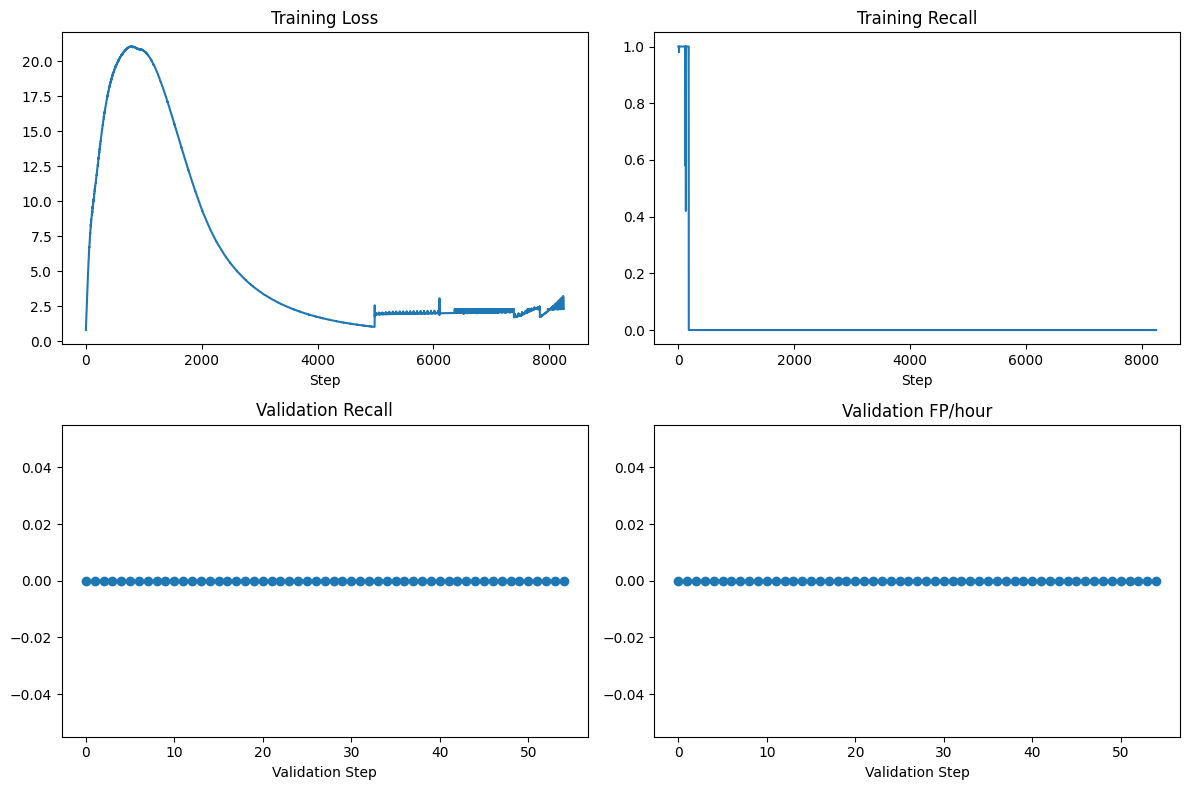

In [210]:
# Inspect training history
import matplotlib.pyplot as plt

history = oww_model.history
print("Training history keys:", list(history.keys()))
print(f"Number of loss samples: {len(history.get('loss', []))}")
print(f"Number of recall samples: {len(history.get('recall', []))}")
print(f"Number of val_recall samples: {len(history.get('val_recall', []))}")
print(f"Number of val_accuracy samples: {len(history.get('val_accuracy', []))}")
print(f"Number of val_fp_per_hr samples: {len(history.get('val_fp_per_hr', []))}")
print(f"Number of best models saved: {len(oww_model.best_models)}")

if history.get('loss'):
    print(f"\nLoss - first: {history['loss'][0]:.4f}, last: {history['loss'][-1]:.4f}")
if history.get('recall'):
    print(f"Recall - first: {history['recall'][0]:.4f}, last: {history['recall'][-1]:.4f}")
if history.get('val_recall'):
    print(f"Val Recall: {history['val_recall']}")
if history.get('val_accuracy'):
    print(f"Val Accuracy: {history['val_accuracy']}")
if history.get('val_fp_per_hr'):
    print(f"Val FP/hr: {history['val_fp_per_hr']}")

# Plot if we have data
if history.get('loss') and len(history['loss']) > 10:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(history['loss'])
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Step')
    
    if history.get('recall'):
        axes[0, 1].plot(history['recall'])
        axes[0, 1].set_title('Training Recall')
        axes[0, 1].set_xlabel('Step')
    
    if history.get('val_recall'):
        axes[1, 0].plot(history['val_recall'], 'o-')
        axes[1, 0].set_title('Validation Recall')
        axes[1, 0].set_xlabel('Validation Step')
    
    if history.get('val_fp_per_hr'):
        axes[1, 1].plot(history['val_fp_per_hr'], 'o-')
        axes[1, 1].set_title('Validation FP/hour')
        axes[1, 1].set_xlabel('Validation Step')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough training data to plot - model may not have trained properly")

In [211]:
# Export the trained model
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

oww_model.export_model(
    model=best_model,
    model_name=MODEL_OUTPUT_NAME,
    output_dir=str(OUTPUT_DIR)
)

print(f"\nModel exported to: {OUTPUT_DIR}")


Model exported to: D:\GitHub\voice-gateway\scripts\wakeword_training\my_custom_model


## 10. Done!

Your trained model is in the `my_custom_model` folder.

In [212]:
print(f"\nTraining complete! Model files:")
if OUTPUT_DIR.exists():
    for f in OUTPUT_DIR.glob("*"):
        if f.is_file():
            size_mb = f.stat().st_size / (1024 * 1024)
            print(f"  {f.name} ({size_mb:.2f} MB)")
else:
    print(f"  Output directory not found: {OUTPUT_DIR}")


Training complete! Model files:
  Seraphina.onnx (0.20 MB)


In [213]:
# Optional: Copy to wakewords folder
import shutil

WAKEWORD_DIR = SCRIPT_DIR.parent / "wakewords" / TARGET_WORD.lower().replace(" ", "_")
WAKEWORD_DIR.mkdir(parents=True, exist_ok=True)

for ext in [".onnx", ".tflite"]:
    src = OUTPUT_DIR / f"{MODEL_OUTPUT_NAME}{ext}"
    if src.exists():
        dst = WAKEWORD_DIR / f"{MODEL_OUTPUT_NAME}{ext}"
        shutil.copy(src, dst)
        print(f"Copied {src.name} to {dst}")

Copied Seraphina.onnx to D:\GitHub\voice-gateway\scripts\wakewords\seraphina\Seraphina.onnx


In [214]:
# Test the model
import openwakeword
from openwakeword.model import Model as OWWModel

# Load trained model
model_path = OUTPUT_DIR / f"{MODEL_OUTPUT_NAME}.onnx"
if model_path.exists():
    oww = OWWModel(wakeword_models=[str(model_path)])
    
    # Test on multiple positive samples
    test_clips = list(POSITIVE_TEST_DIR.glob("*.wav"))[:5]
    print(f"Testing on {len(test_clips)} positive samples...")
    
    for test_clip in test_clips:
        oww.reset()  # Reset buffer between clips
        audio, sr = torchaudio.load(str(test_clip))
        audio = audio.squeeze().numpy()
        
        # Resample to 16kHz if needed
        if sr != 16000:
            audio = torchaudio.functional.resample(torch.from_numpy(audio), sr, 16000).numpy()
        
        # Convert to int16
        audio_int16 = (audio * 32767).astype(np.int16)
        
        # Stream audio in chunks (80ms = 1280 samples at 16kHz)
        chunk_size = 1280
        max_score = 0.0
        for i in range(0, len(audio_int16) - chunk_size, chunk_size):
            chunk = audio_int16[i:i+chunk_size]
            prediction = oww.predict(chunk)
            score = prediction.get(MODEL_OUTPUT_NAME, 0.0)
            max_score = max(max_score, score)
        
        print(f"  {test_clip.name}: max_score={max_score:.4f}")
    
    # Also test on a negative sample for comparison
    print("\nTesting on negative samples...")
    neg_clips = list(NEGATIVE_TEST_DIR.glob("*.wav"))[:3]
    for test_clip in neg_clips:
        oww.reset()
        audio, sr = torchaudio.load(str(test_clip))
        audio = audio.squeeze().numpy()
        if sr != 16000:
            audio = torchaudio.functional.resample(torch.from_numpy(audio), sr, 16000).numpy()
        audio_int16 = (audio * 32767).astype(np.int16)
        
        max_score = 0.0
        for i in range(0, len(audio_int16) - chunk_size, chunk_size):
            chunk = audio_int16[i:i+chunk_size]
            prediction = oww.predict(chunk)
            score = prediction.get(MODEL_OUTPUT_NAME, 0.0)
            max_score = max(max_score, score)
        
        print(f"  {test_clip.name}: max_score={max_score:.4f}")
else:
    print(f"Model not found at {model_path}")

Testing on 5 positive samples...
  sample_00001.wav: max_score=0.0010
  sample_00003.wav: max_score=0.0010
  sample_00005.wav: max_score=0.0010
  sample_00007.wav: max_score=0.0010
  sample_00009.wav: max_score=0.0010

Testing on negative samples...
  sample_00001.wav: max_score=0.0010
  sample_00004.wav: max_score=0.0010
  sample_00005.wav: max_score=0.0010
